# Let's start by importing the libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import keras
from keras.layers import Dense 
from keras.optimizers import SGD 
from keras.models import Sequential
from keras.layers import Flatten 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout

Using TensorFlow backend.


## Definition of some useful functions

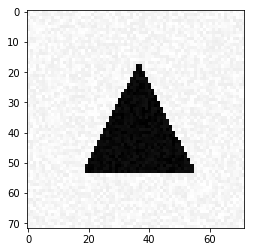

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


## 3. Simple Classification

#### 3.1 Model and visualisation with adam optimizer

In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
100
200


In [4]:
from keras.utils import np_utils 
y_train = np_utils.to_categorical(Y_train, 3)

In [31]:
model_adam = Sequential()
model_adam.add(Dense(3, input_shape = (5184,)) )
model_adam.add(Dense(3, activation='softmax') )
print(model_adam.output_shape)
model_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 
model_adam.fit(X_train,y_train, epochs=20, verbose=1) 

(None, 3)


In [6]:
model_adam.evaluate(X_train, y_train)

300/300 [==============================] - 0s 675us/step


[0.08745917677879333, 1.0]

Let's plot the results

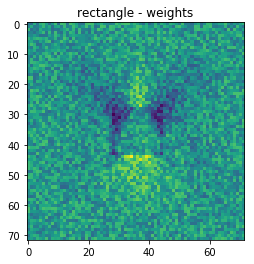

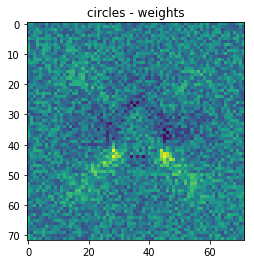

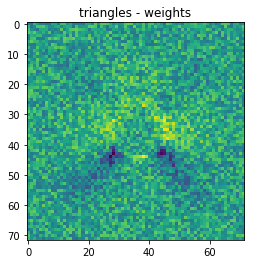

In [7]:
def plot_weights(model):
    column_rectangle = model.get_weights()[0][:,0]
    plt.figure()
    plt.title('rectangle - weights')
    imgplot1 = plt.imshow(column_rectangle.reshape(IMAGE_SIZE,IMAGE_SIZE))
    
    column_circle = model.get_weights()[0][:,1]
    plt.figure()
    plt.title('circles - weights')
    imgplot2 = plt.imshow(column_circle.reshape(IMAGE_SIZE,IMAGE_SIZE))

    column_triangle = model.get_weights()[0][:,2]
    plt.figure()
    plt.title('triangles - weights')
    imgplot3 = plt.imshow(column_triangle.reshape(IMAGE_SIZE,IMAGE_SIZE))
    
plot_weights(model_adam)

#### 3.2 Now for the stochastic gradient descent

In [32]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model_sgd = Sequential()
model_sgd.add(Dense(3, input_shape = (5184,)) )
model_sgd.add(Dense(3, activation='softmax') )
print(model_sgd.output_shape)
model_sgd.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy']) 
model_sgd.fit(X_train,y_train, epochs=20, verbose=1) 

(None, 3)


In [9]:
model_sgd.evaluate(X_train, y_train)

300/300 [==============================] - 0s 678us/step


[10.10067310333252, 0.37333333373069766]

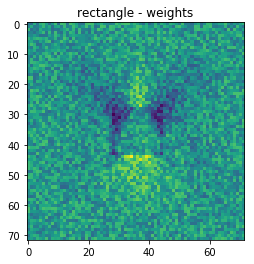

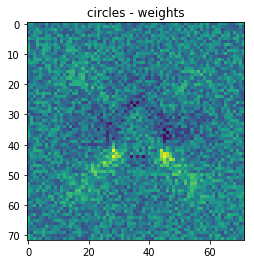

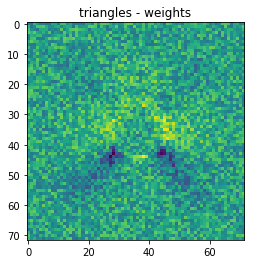

In [10]:
plot_weights(model_adam)

## 5. A more difficult classification problem

#### 5.1 Generation of the data

In [30]:
n_train = 7000
n_test = 300
[X_train1, Y_train1] = generate_dataset_classification(n_train, 20, True)
[X_test1, Y_test1] = generate_test_set_classification()
X_train11= X_train1.reshape(n_train,72,72)
X_test11 = X_test1.reshape(n_test, 72,72)
y_train1 = np_utils.to_categorical(Y_train1, 3)
y_test1 = np_utils.to_categorical(Y_test1, 3)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
Creating data:
0
100
200


#### 5.2 Test with basic networks

In [33]:
model_adam.fit(X_train1,y_train1, epochs=20, verbose=0) 

In [34]:
model_adam.evaluate(X_test1, Y_test1)

300/300 [==============================] - 0s 874us/step


[0.6917992647488912, 0.6333333333333333]

In [35]:
model_sgd.fit(X_train1,y_train1, epochs=20, verbose=0) 

In [36]:
model_sgd.evaluate(X_test1, Y_test1)

300/300 [==============================] - 0s 951us/step


[10.799123992919922, 0.33]

We can note that while with the adam optimizer the network keeps a performance above average, the network optimized with the stochastic gradient descent is completely lost and get an accuracy of about 0.33.

#### 5.2 Using a convolutionnal layer in the network

In [37]:
X_train11 = X_train11.reshape(n_train, 72, 72, 1) 
X_train11 = X_train11.astype('float32') 

X_test11 = X_test11.reshape(n_test, 72, 72, 1) 
X_test11 = X_test11.astype('float32') 

In [42]:
model_conv = Sequential() 
model_conv.add(Conv2D(62, (15, 15), activation='relu', input_shape=(72, 72, 1))) 
model_conv.add(MaxPooling2D(5))
model_conv.add(Flatten())
model_conv.add(Dense(units=30, activation="relu"))
#model_conv.add(Dropout(0.5))
model_conv.add(Dense(3, activation="softmax"))
model_conv.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [43]:
model_conv.fit(X_train11, y_train1, epochs=20, verbose=1) 

Epoch 1/20
7000/7000 [==============================] - 4s 507us/step - loss: 0.8345 - acc: 0.5644
Epoch 2/20
7000/7000 [==============================] - 3s 384us/step - loss: 0.6749 - acc: 0.6474
Epoch 3/20
7000/7000 [==============================] - 3s 384us/step - loss: 0.5648 - acc: 0.7346
Epoch 4/20
7000/7000 [==============================] - 3s 386us/step - loss: 0.4398 - acc: 0.8067
Epoch 5/20
7000/7000 [==============================] - 3s 382us/step - loss: 0.2946 - acc: 0.8896
Epoch 6/20
7000/7000 [==============================] - 3s 391us/step - loss: 0.2021 - acc: 0.9267
Epoch 7/20
7000/7000 [==============================] - 3s 384us/step - loss: 0.1552 - acc: 0.9429
Epoch 8/20
7000/7000 [==============================] - 3s 387us/step - loss: 0.1215 - acc: 0.9570
Epoch 9/20
7000/7000 [==============================] - 3s 391us/step - loss: 0.0986 - acc: 0.9666
Epoch 10/20
7000/7000 [==============================] - 3s 394us/step - loss: 0.0859 - acc: 0.9701
Epoch 11/

In [44]:
model_conv.evaluate(X_test11, Y_test1)

300/300 [==============================] - 0s 1ms/step


[0.16463922878106435, 0.9533333325386047]

## 6. A regression problem

#### 6.1 Generating and preprocessing the dataset

In [62]:
n_train = 7000
[X_train_r, y_train_r] = generate_dataset_regression(n_train, 20)
[X_test_r, y_test_r] = generate_dataset_regression(300, 20)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
Creating data:
0
100
200


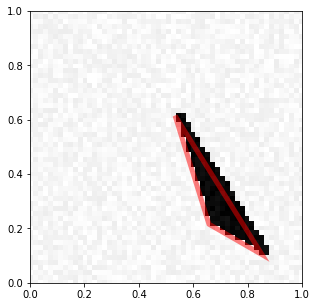

In [63]:
visualize_prediction(X_train_r[1], y_train_r[1])

In order to ease the regression, the output should be formated such as the X labels are sorted in ascending order

In [64]:
def normalize(y_input):
    #the output has 6 values
    y_output = np.zeros(6)
    ordered_arg_x = list(np.argsort([y_input[2*j] for j in range(3)]))
    index_output = 0
    for i in ordered_arg_x:
        index_input = 2*i
        y_output[index_output] = y_input[index_input]
        index_output += 1
        y_output[index_output] = y_input[index_input+1]
        index_output += 1
    return y_output

In [65]:
X_train_r = X_train_r.reshape(n_train,72,72,1)
X_test_r = X_test_r.reshape(300,72,72,1)
Y_train_r = np.apply_along_axis(normalize, 1, y_train_r)
Y_test_r = np.apply_along_axis(normalize, 1, y_test_r)

#### 6.2 Creating a regressor

In [71]:
model_conv_r = Sequential()
model_conv_r.add(Conv2D(filters=64, kernel_size=(10,10), input_shape=(72, 72, 1)))
model_conv_r.add(MaxPooling2D(10))
#model_conv_r.add(Dropout(0.25))
model_conv_r.add(Flatten())
model_conv_r.add(Dense(units=30, activation="relu"))
model_conv_r.add(Dense(6, activation="linear"))
model_conv_r.compile(loss="mean_squared_error",optimizer='adam',metrics=['mse'])

In [72]:
model_conv_r.fit(X_train_r, Y_train_r, epochs=100, verbose=1) 

Epoch 1/100
7000/7000 [==============================] - 4s 505us/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 2/100
7000/7000 [==============================] - 3s 369us/step - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 3/100
7000/7000 [==============================] - 3s 371us/step - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 4/100
7000/7000 [==============================] - 2s 354us/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 5/100
7000/7000 [==============================] - 2s 352us/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 6/100
7000/7000 [==============================] - 3s 360us/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 7/100
7000/7000 [==============================] - 3s 357us/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 8/100
7000/7000 [==============================] - 2s 349us/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 9/100
7000/7000 [==============================] - 2s 356us/step - loss: 0

7000/7000 [==============================] - 2s 356us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 72/100
7000/7000 [==============================] - 3s 357us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 73/100
7000/7000 [==============================] - 3s 358us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 74/100
7000/7000 [==============================] - 3s 361us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 75/100
7000/7000 [==============================] - 3s 358us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 76/100
7000/7000 [==============================] - 3s 358us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 77/100
7000/7000 [==============================] - 2s 356us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 78/100
7000/7000 [==============================] - 3s 360us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 79/100
7000/7000 [==============================] - 3s 368us/step - loss: 0.001

At the end of the training time, the mean squared error is 0.0016, which should be precise enough to make the regression on new datas

In [78]:
Y_test_r_pred = model_conv_r.predict(X_test_r)

#### 6.3 Visualization of the solution

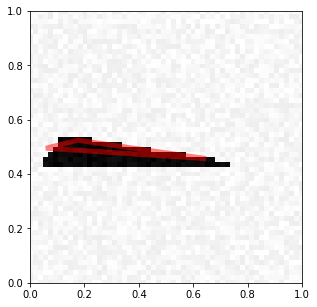

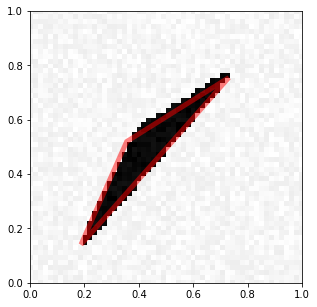

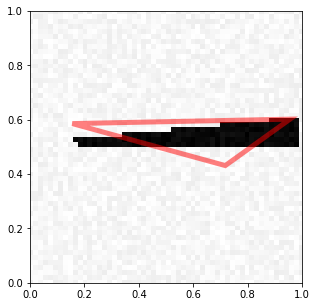

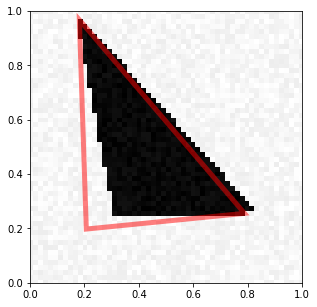

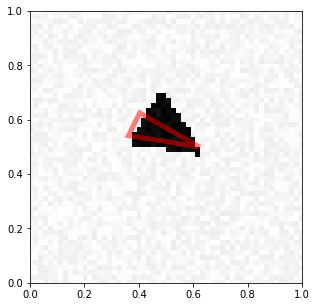

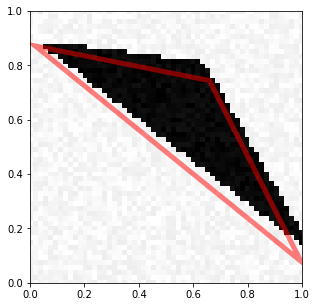

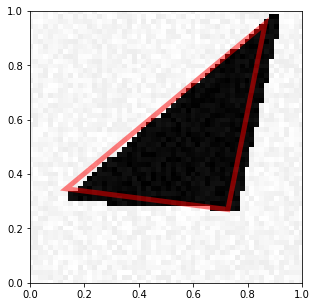

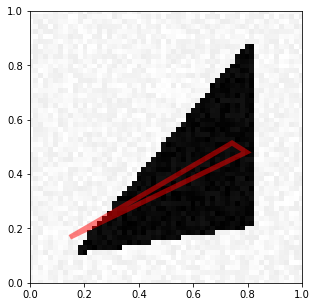

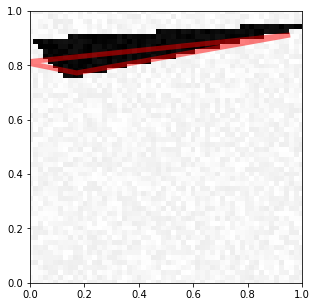

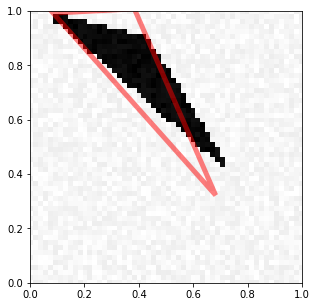

In [79]:
for i in range(10):
    visualize_prediction(X_test_r[i], Y_test_r_pred[i])